In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))
    

def evaluate_bh(pvals, labels, alpha):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]
    
    # Apply BH
    purity_test = len(idx_in)/len(pvals)
    reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

    # Evaluate FDP and Power
    rejections = np.sum(reject)
    if rejections > 0:
        fdp = np.sum(reject[idx_in])/reject.shape[0] 
        power = np.sum(reject[idx_out])/len(idx_out)
    else:
        fdp = 0
        power = 0
    return fdp, power

def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [3]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment 1: CES for anomaly detection

### Load MNIST dataset

In [4]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

In [5]:
from datasetMaker import get_class_i, DatasetMaker

x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 8
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


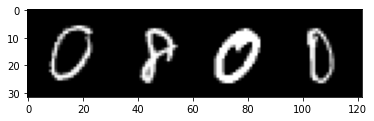

In [6]:
# Plot some sample test data
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), norm=False)

### Benchmark data-splitting vs CES data-splitting

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_data = 300
n_train_bm = 100
n_val_bm = 100
n_cal_bm = 100

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = 200
n_val_ces = 100

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [8]:
# Create data loader objects
# For benchmarks
batch_size = 10
num_workers = 0

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                          num_workers=num_workers)

In [9]:
# Test loader

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

### Define Autoencoder

In [10]:
from method import CES_oneClass
from networks import ConvAutoencoder
import torch.optim as optim

# Define the model parameters

lr = 0.01
n_epoch = 10

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [11]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train benchmark models and compute conformal p-values

In [12]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 10
learning_rate= 0.01


In [13]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_bm.full_train(save_dir = './models/oneClass/benchmarks', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 0.30  took: 0.06s
Epoch 1 of 10, 20% 	 train_loss: 0.29  took: 0.05s
Epoch 1 of 10, 30% 	 train_loss: 0.29  took: 0.07s
Epoch 1 of 10, 40% 	 train_loss: 0.28  took: 0.10s
Epoch 1 of 10, 50% 	 train_loss: 0.26  took: 0.11s
Epoch 1 of 10, 60% 	 train_loss: 0.25  took: 0.10s
Epoch 1 of 10, 70% 	 train_loss: 0.23  took: 0.09s
Epoch 1 of 10, 80% 	 train_loss: 0.21  took: 0.01s
Epoch 1 of 10, 90% 	 train_loss: 0.20  took: 0.02s
Epoch 1 of 10, 100% 	 train_loss: 0.19  took: 0.02s
val_loss = 0.19
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 0.19  took: 0.05s
Epoch 2 of 10, 20% 	 train_loss: 0.18  took: 0.04s
Epoch 2 of 10, 30% 	 train_loss: 0.15  took: 0.03s
Epoch 2 of 10, 40% 	 train_loss: 0.16  took: 0.02s
Epoch 2 of 10, 50% 	 train_loss: 0.15  took: 0.00s
Epoch 2 of 10, 60% 	 train_loss: 0.16  took: 0.01s
Epoch 2 of 10, 70% 	 train_loss: 0.15  took: 0.00s
Epoch 2 of 10, 80% 	 train_loss: 0.14  took: 0.01s
Epoch 2 of 10, 90% 	 train_loss: 0.15 

In [14]:
import time

# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_oc_bm.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 2303.12it/s]

selecting models takes: 8.100912809371948


In [15]:
from inference import Conformal_PVals

model_list_bm = CES_oc_bm.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_bm = Conformal_PVals(net_bm, device, cal_loader_bm, model_list_bm, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.57it/s]

Initialization done!
Calibration (one time effort) takes:0.20s.


In [16]:
pvals_bm = C_PVals_bm.compute_pvals(inputs, best_model_bm)

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:02<00:00, 899.45it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.514599, average p-value for outliers is 0.610951.


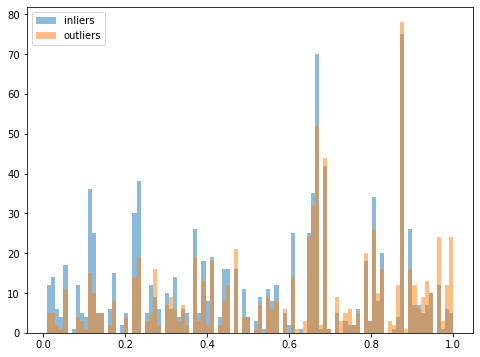

In [17]:
plot_pvals(pvals_bm, labels)

In [19]:
fdp, power = evaluate_bh(pvals_bm, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.000000, power 0.000000.


### Train the CES models

In [20]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)


# Initialize the CES class with model parameters
CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 10
learning_rate= 0.01


In [21]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_ces.full_train(save_dir = './models/oneClass/ces', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 0.17  took: 0.21s
Epoch 1 of 10, 20% 	 train_loss: 0.16  took: 0.22s
Epoch 1 of 10, 30% 	 train_loss: 0.16  took: 0.17s
Epoch 1 of 10, 40% 	 train_loss: 0.15  took: 0.19s
Epoch 1 of 10, 50% 	 train_loss: 0.14  took: 0.03s
Epoch 1 of 10, 60% 	 train_loss: 0.13  took: 0.02s
Epoch 1 of 10, 70% 	 train_loss: 0.11  took: 0.02s
Epoch 1 of 10, 80% 	 train_loss: 0.09  took: 0.02s
Epoch 1 of 10, 90% 	 train_loss: 0.08  took: 0.02s
Epoch 1 of 10, 100% 	 train_loss: 0.06  took: 0.02s
val_loss = 0.05
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 0.06  took: 0.02s
Epoch 2 of 10, 20% 	 train_loss: 0.05  took: 0.02s
Epoch 2 of 10, 30% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 40% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 50% 	 train_loss: 0.04  took: 0.01s
Epoch 2 of 10, 60% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 70% 	 train_loss: 0.04  took: 0.04s
Epoch 2 of 10, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 2 of 10, 90% 	 train_loss: 0.03 

In [22]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_oc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 2177.51it/s]

selecting models takes: 8.19605040550232


In [23]:
model_list_ces = CES_oc_ces.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_ces = Conformal_PVals(net_ces, device, val_loader_ces, model_list_ces, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.87it/s]

Initialization done!
Calibration (one time effort) takes:0.22s.


In [24]:
pvals_ces = C_PVals_ces.compute_pvals(inputs, best_model_ces)

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:02<00:00, 766.70it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.523348, average p-value for outliers is 0.094337.


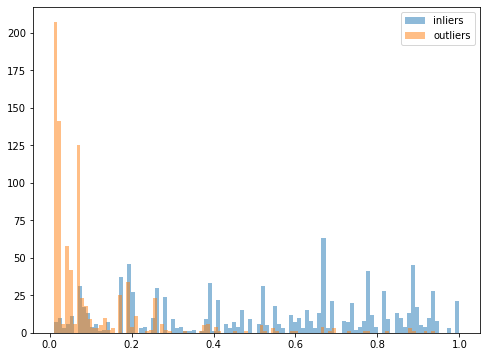

In [25]:
plot_pvals(pvals_ces, labels)

In [27]:
fdp, power = evaluate_bh(pvals_ces, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.047222, power 0.741463.


# Experiment 2: CES for multi-class classification

### Load CIFAR10 dataset

In [29]:
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Benchmark data-splitting vs CES data-splitting

In [31]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_data = 4000
n_train_bm = 2000
n_val_bm = 1000
n_cal_bm = 1000

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = 3000
n_val_ces = 1000

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [32]:
# Create data loader objects
# For benchmarks
batch_size = 64
num_workers = 4

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=100,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=100,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=100,
                                          num_workers=num_workers)

In [33]:
# Test loader

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 2000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

      bird      plane       deer       bird


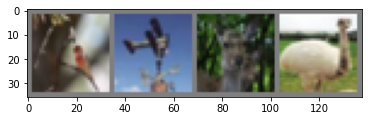

In [35]:
# Plot some sample test data

imshow(torchvision.utils.make_grid(inputs[:4]), norm=True)
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(4)))

### Define CNN

In [36]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [38]:
import torch.optim as optim

# Define the model parameters
lr = 0.001
n_epoch = 10
n_classes = len(classes)

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [39]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train the benchmark model

In [40]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc_bm = CES_multiClass(net_bm, device, train_loader_bm, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [41]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_bm.full_train(save_dir = './models/multiClass/benchmarks', save_every = save_every)

Epoch 1 of 10, 9% 	 train_loss: 2.29 train_acc: 14.06% took: 5.57s
Epoch 1 of 10, 18% 	 train_loss: 2.23 train_acc: 16.15% took: 0.05s
Epoch 1 of 10, 28% 	 train_loss: 2.16 train_acc: 22.40% took: 0.06s
Epoch 1 of 10, 37% 	 train_loss: 2.08 train_acc: 24.48% took: 0.06s
Epoch 1 of 10, 46% 	 train_loss: 2.01 train_acc: 25.00% took: 0.06s
Epoch 1 of 10, 56% 	 train_loss: 2.08 train_acc: 27.08% took: 0.06s
Epoch 1 of 10, 65% 	 train_loss: 1.98 train_acc: 27.60% took: 0.07s
Epoch 1 of 10, 75% 	 train_loss: 2.04 train_acc: 31.25% took: 0.05s
Epoch 1 of 10, 84% 	 train_loss: 1.93 train_acc: 33.33% took: 0.06s
Epoch 1 of 10, 93% 	 train_loss: 1.86 train_acc: 31.77% took: 0.06s
val_loss = 1.89 val_acc = 31.80%
Snapshot saved at epoch 1.
Epoch 2 of 10, 9% 	 train_loss: 1.76 train_acc: 39.06% took: 5.44s
Epoch 2 of 10, 18% 	 train_loss: 1.85 train_acc: 29.69% took: 0.05s
Epoch 2 of 10, 28% 	 train_loss: 1.81 train_acc: 34.90% took: 0.05s
Epoch 2 of 10, 37% 	 train_loss: 1.76 train_acc: 41.67% to

In [42]:
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list_bm = CES_mc_bm.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_bm = Conformal_PSet(net_bm, device, cal_loader_bm, n_classes, model_list_bm, \
                           alpha,random_state = 2023)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]

Initialization done!
Calibration (one time effort) takes:60.31s.


In [43]:
# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_mc_bm.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 280.71it/s]

Loading model 1 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 282.97it/s]

Loading model 2 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 273.00it/s]

Loading model 3 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 242.52it/s]

Loading model 4 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 190.58it/s]

Loading model 5 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 177.87it/s]

Loading model 6 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 169.12it/s]

Loading model 7 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 161.89it/s]

Loading model 8 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 187.59it/s]

Loading model 9 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.34it/s]

selecting models takes: 97.02794241905212


In [44]:
# Get the marginal conformal pvalues 
pset_m_bm= C_PSet_bm.pred_set(inputs, best_model_bm, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_bm = C_PSet_bm.pred_set(inputs, best_model_bm, marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 39.11it/s]


Finished computing marginal prediction sets for 2000 test points.


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.42it/s]

Finished computing label conditional prediction sets for 2000 test points.


In [48]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_bm, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       91.050%
Average size:            4.924
Average size | coverage: 4.941
Conditional coverage for label plane:       88.265%
Average size:            4.709
Average size | coverage: 4.613
Conditional coverage for label car:       94.949%
Average size:            3.611
Average size | coverage: 3.601
Conditional coverage for label bird:       89.744%
Average size:            5.149
Average size | coverage: 5.314
Conditional coverage for label cat:       88.945%
Average size:            5.779
Average size | coverage: 5.893
Conditional coverage for label deer:       96.465%
Average size:            5.369
Average size | coverage: 5.372
Conditional coverage for label dog:       84.865%
Average size:            5.411
Average size | coverage: 5.516
Conditional coverage for label frog:       96.759%
Average size:            4.866
Average size | coverage: 4.895
Conditional coverage for label horse:       86.010%
Average size:            5.81

In [49]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_bm, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       91.650%
Average size:            4.941
Average size | coverage: 4.980
Conditional coverage for label plane:       88.776%
Average size:            4.684
Average size | coverage: 4.563
Conditional coverage for label car:       90.404%
Average size:            3.636
Average size | coverage: 3.598
Conditional coverage for label bird:       90.769%
Average size:            5.287
Average size | coverage: 5.508
Conditional coverage for label cat:       90.955%
Average size:            5.729
Average size | coverage: 5.773
Conditional coverage for label deer:       92.929%
Average size:            5.561
Average size | coverage: 5.636
Conditional coverage for label dog:       96.216%
Average size:            5.238
Average size | coverage: 5.292
Conditional coverage for label frog:       95.370%
Average size:            5.125
Average size | coverage: 5.180
Conditional coverage for label horse:       90.674%
Average size:       

### Train the CES model

In [51]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)

# Initialize the CES class with model parameters
CES_mc_ces = CES_multiClass(net_ces, device, train_loader_ces, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [52]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [53]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_ces.full_train(save_dir = './models/multiClass/ces', save_every = save_every)

Epoch 1 of 10, 8% 	 train_loss: 2.26 train_acc: 17.97% took: 5.57s
Epoch 1 of 10, 17% 	 train_loss: 2.22 train_acc: 16.41% took: 0.07s
Epoch 1 of 10, 25% 	 train_loss: 2.11 train_acc: 25.39% took: 0.06s
Epoch 1 of 10, 34% 	 train_loss: 2.05 train_acc: 28.91% took: 0.07s
Epoch 1 of 10, 42% 	 train_loss: 2.05 train_acc: 23.05% took: 0.06s
Epoch 1 of 10, 51% 	 train_loss: 2.06 train_acc: 25.78% took: 0.08s
Epoch 1 of 10, 59% 	 train_loss: 2.01 train_acc: 27.73% took: 0.07s
Epoch 1 of 10, 68% 	 train_loss: 1.96 train_acc: 28.12% took: 0.06s
Epoch 1 of 10, 76% 	 train_loss: 1.93 train_acc: 28.12% took: 0.06s
Epoch 1 of 10, 85% 	 train_loss: 1.79 train_acc: 39.45% took: 0.08s
Epoch 1 of 10, 93% 	 train_loss: 1.90 train_acc: 31.64% took: 0.06s
val_loss = 1.83 val_acc = 34.20%
Snapshot saved at epoch 1.
Epoch 2 of 10, 8% 	 train_loss: 1.77 train_acc: 36.72% took: 5.86s
Epoch 2 of 10, 17% 	 train_loss: 1.77 train_acc: 40.23% took: 0.07s
Epoch 2 of 10, 25% 	 train_loss: 1.79 train_acc: 35.94% to

In [54]:
alpha = 0.1
model_list_ces = CES_mc_ces.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_ces = Conformal_PSet(net_ces, device, val_loader_ces, n_classes, model_list_ces, \
                           alpha,random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.11s/it]

Initialization done!
Calibration (one time effort) takes:71.08s.


In [55]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_mc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 257.08it/s]

Loading model 1 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 183.39it/s]

Loading model 2 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 187.50it/s]

Loading model 3 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.73it/s]

Loading model 4 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 181.11it/s]

Loading model 5 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.71it/s]

Loading model 6 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.64it/s]

Loading model 7 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.13it/s]

Loading model 8 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 187.93it/s]

Loading model 9 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.44it/s]

selecting models takes: 104.24921941757202


In [56]:
# Get the marginal conformal pvalues 
pset_m_ces= C_PSet_ces.pred_set(inputs, best_model_ces, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_ces = C_PSet_ces.pred_set(inputs, best_model_ces, marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.22it/s]


Finished computing marginal prediction sets for 2000 test points.


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 41.73it/s]

Finished computing label conditional prediction sets for 2000 test points.


In [57]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_ces, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       90.750%
Average size:            4.452
Average size | coverage: 4.482
Conditional coverage for label plane:       85.714%
Average size:            3.730
Average size | coverage: 3.607
Conditional coverage for label car:       95.960%
Average size:            3.566
Average size | coverage: 3.537
Conditional coverage for label bird:       90.769%
Average size:            4.626
Average size | coverage: 4.768
Conditional coverage for label cat:       83.417%
Average size:            5.503
Average size | coverage: 5.663
Conditional coverage for label deer:       91.919%
Average size:            4.742
Average size | coverage: 4.775
Conditional coverage for label dog:       94.595%
Average size:            4.924
Average size | coverage: 4.994
Conditional coverage for label frog:       94.907%
Average size:            5.157
Average size | coverage: 5.210
Conditional coverage for label horse:       91.192%
Average size:            4.95

In [58]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_ces, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       90.100%
Average size:            4.410
Average size | coverage: 4.452
Conditional coverage for label plane:       88.776%
Average size:            3.612
Average size | coverage: 3.511
Conditional coverage for label car:       94.444%
Average size:            3.722
Average size | coverage: 3.717
Conditional coverage for label bird:       91.282%
Average size:            4.533
Average size | coverage: 4.702
Conditional coverage for label cat:       88.442%
Average size:            5.397
Average size | coverage: 5.528
Conditional coverage for label deer:       83.333%
Average size:            4.763
Average size | coverage: 4.861
Conditional coverage for label dog:       88.649%
Average size:            4.795
Average size | coverage: 4.860
Conditional coverage for label frog:       93.056%
Average size:            5.083
Average size | coverage: 5.154
Conditional coverage for label horse:       91.192%
Average size:       